In [45]:
import json
import numpy as np
import matplotlib.pyplot as plt


from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

import util; reload(util)


<module 'util' from 'util.py'>

In [5]:
%matplotlib inline

In [37]:
# Lag stivariabler
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/suitsglasses'


%pwd
path = "data/suitsglasses/"



In [20]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [21]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [22]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [23]:
model = VGG_16()

/home/kurs/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [24]:
# Load precalculated weights
fpath = LESSON_HOME_DIR + '/models/vgg16.h5'
model.load_weights(fpath)

In [25]:
batch_size = 64

In [26]:
def finetune(model, num):
    """
        Replace the last layer of the model with a Dense (fully connected) layer of num neurons.
        Will also lock the weights of all layers except the new layer so that we only learn
        weights for the last layer in subsequent training.

        Args:
            num (int) : Number of neurons in the Dense layer
        Returns:
            None
    """
    model.pop()
    for layer in model.layers: layer.trainable=False
    model.add(Dense(num, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.0001),
                loss='categorical_crossentropy', metrics=['accuracy'])
    model.classes = ['glasses', 'suits']

In [27]:
def fit(model, batches, val_batches, nb_epoch=1):
    """
        Fits the model on data yielded batch-by-batch by a Python generator.
        See Keras documentation: https://keras.io/models/model/
    """
    model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
            validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

data/suitsglasses/train
Found 709 images belonging to 2 classes.


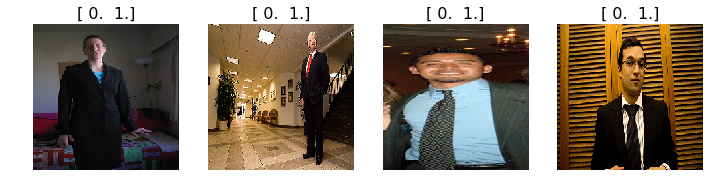

In [48]:
batches = util.get_batches(path+'train', batch_size=4)

imgs,labels = next(batches)
# This shows the 'ground truth'
util.plots(imgs, titles=labels)

In [50]:
batches = util.get_batches(path+'train', batch_size=batch_size)
val_batches = util.get_batches(path+'valid', batch_size=batch_size)
finetune(model,2)
fit(model, batches, val_batches, nb_epoch=1)



Found 709 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/1
709/709 [==============================] - 26s - loss: 1.1917 - acc: 0.6164 - val_loss: 0.5867 - val_acc: 0.7300


In [51]:
# save the model weights
fpath = LESSON_HOME_DIR + '/models/vgg16_sg.h5'
print(fpath)
model.save_weights(fpath)

/data/JCH/ConsultantOrNot/models/vgg16_sg.h5


In [52]:
def predict(model, imgs, details=False):
    """
        Predict the labels of a set of images using the VGG16 model.

        Args:
            imgs (ndarray)    : An array of N images (size: N x width x height x channels).
            details : ??

        Returns:
            preds (np.array) : Highest confidence value of the predictions for each image.
            idxs (np.ndarray): Class index of the predictions with the max confidence.
            classes (list)   : Class labels of the predictions with the max confidence.
    """
    # predict probability of each class for each image
    all_preds = model.predict(imgs)
    # for each image get the index of the class with max probability
    idxs = np.argmax(all_preds, axis=1)
    # get the values of the highest probability for each image
    preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
    # get the label of the class with the highest probability for each image
    classes = [model.classes[idx] for idx in idxs]
    return np.array(preds), idxs, classes

Found 9 images belonging to 1 classes.


(array([ 0.70223224,  0.73924828,  0.68990713,  0.71166271], dtype=float32),
 array([1, 1, 0, 1]),
 ['suits', 'suits', 'glasses', 'suits'])

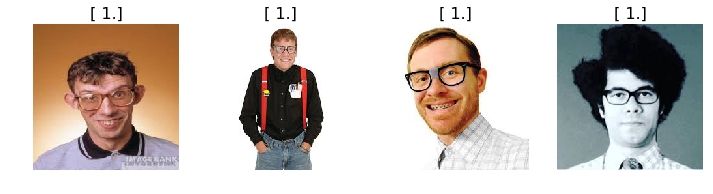

In [53]:
# Prediker på våre testdata
batches = util.get_batches(path+'test', batch_size=4)
imgs,labels = next(batches)

util.plots(imgs, titles=labels)

predict(model, imgs, True)